In [5]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

# Load dataset
df = pd.read_csv("sample_conjoint_large.csv")

# One-hot encode categorical columns
categorical_cols = ['Salary', 'Location', 'CompanyType', 'Growth', 'WorkLife', 'JobSecurity']
encoder = OneHotEncoder(drop='first', sparse=False)  # older sklearn syntax
X_encoded = encoder.fit_transform(df[categorical_cols])

# Use get_feature_names (older sklearn)
X = pd.DataFrame(X_encoded, columns=encoder.get_feature_names(categorical_cols))
y = df["Chosen"]

# Fit the multinomial logit model
model = sm.MNLogit(y, X)
result = model.fit(maxiter=100, disp=True)

# Show results
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.680837
         Iterations 4
                          MNLogit Regression Results                          
Dep. Variable:                 Chosen   No. Observations:                  200
Model:                        MNLogit   Df Residuals:                      188
Method:                           MLE   Df Model:                           11
Date:                Tue, 08 Apr 2025   Pseudo R-squ.:                 0.01776
Time:                        19:33:36   Log-Likelihood:                -136.17
converged:                       True   LL-Null:                       -138.63
Covariance Type:            nonrobust   LLR p-value:                    0.9348
           Chosen=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Salary_6 LPA           -0.2135      0.355     -0.601      0.548      -0.910       0.483
Sa

Optimization terminated successfully.
         Current function value: 0.680526
         Iterations 4
                          MNLogit Regression Results                          
Dep. Variable:                 Chosen   No. Observations:                  200
Model:                        MNLogit   Df Residuals:                      187
Method:                           MLE   Df Model:                           12
Date:                Tue, 08 Apr 2025   Pseudo R-squ.:                 0.01821
Time:                        22:33:03   Log-Likelihood:                -136.11
converged:                       True   LL-Null:                       -138.63
Covariance Type:            nonrobust   LLR p-value:                    0.9563
           Chosen=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1868      0.530      0.352      0.725      -0.852       1.226
Sa

C:\Users\Dhakaramaki\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


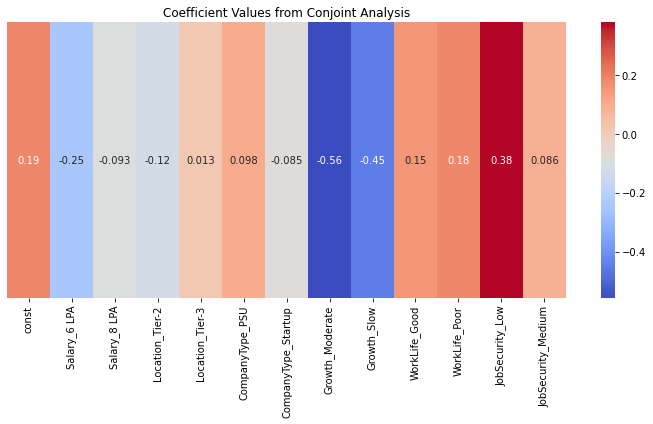

In [23]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load your data ---
# Replace with your actual CSV file path
df = pd.read_csv("sample_conjoint_large.csv")

# --- 2. Prepare data ---
categorical_cols = ['Salary', 'Location', 'CompanyType', 'Growth', 'WorkLife', 'JobSecurity']
target_col = 'Chosen'

# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = encoder.fit_transform(df[categorical_cols])

# Retrieve proper column names
feature_names = encoder.get_feature_names(categorical_cols)
X = pd.DataFrame(X_encoded, columns=feature_names)
X.index = df.index  # ensure the indices match original df

# Add constant for intercept
X = sm.add_constant(X)

# Define target
y = df[target_col]

# --- 3. Fit Multinomial Logit model ---
model = sm.MNLogit(y, X)
result = model.fit()

# --- 4. Show model summary ---
print(result.summary())

# --- 5. Attribute Importance Calculation ---
params_df = result.params.transpose()  # ensure columns are attributes

# Get a dictionary mapping each attribute to its dummy columns
attribute_dict = {}
for name in feature_names:
    attr = name.split('_')[0]
    attribute_dict.setdefault(attr, []).append(name)

# Calculate importance: range of coefficients for each attribute
importance_scores = {}
for attr, cols in attribute_dict.items():
    coefs = result.params.loc[cols].values.flatten()
    importance_scores[attr] = np.max(coefs) - np.min(coefs)

# Normalize to 100%
total_range = sum(importance_scores.values())
importance_percentages = {
    attr: (rng / total_range) * 100 for attr, rng in importance_scores.items()
}

# --- 6. Print importance scores ---
print("\nAttribute Importance Scores (based on utility range):")
for attr, score in sorted(importance_percentages.items(), key=lambda x: -x[1]):
    print(f"{attr}: {score:.2f}%")

# --- 7. (Optional) Plot coefficients heatmap ---
plt.figure(figsize=(10, 6))
coef_values = result.params.T.squeeze()
sns.heatmap(coef_values.to_frame().T, annot=True, cmap="coolwarm", cbar=True)
plt.title("Coefficient Values from Conjoint Analysis")
plt.yticks([])
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

# Load your dataset
df = pd.read_csv("sample_conjoint_large.csv")  # Replace with your actual file path

# Define categorical columns
categorical_cols = ['Salary', 'Location', 'CompanyType', 'Growth', 'WorkLife', 'JobSecurity']
y = df['Chosen']

# One-hot encode (drop first to avoid dummy variable trap)
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = encoder.fit_transform(df[categorical_cols])
feature_names = encoder.get_feature_names(categorical_cols)
X_df = pd.DataFrame(X_encoded, columns=feature_names)

# Fit the model
X_with_const = sm.add_constant(X_df)
model = sm.MNLogit(y, X_with_const)
result = model.fit()

# Get and clean coefficient table (drop 'const')
coef_df = result.summary2().tables[1]
coef_df = coef_df[~coef_df.index.str.contains('const', case=False)]

# Display cleaned coefficient table
print("Regression Coefficients (without constant):")
print(coef_df)

# --- Attribute Importance ---
# Use the cleaned index from coef_df
attribute_groups = {}
for feature in coef_df.index:
    attr_name = feature.split('_')[0]  # 'Salary_6 LPA' → 'Salary'
    attribute_groups.setdefault(attr_name, []).append(abs(coef_df.loc[feature, 'Coef.']))

# Calculate utility ranges
attribute_ranges = {}
for attr, values in attribute_groups.items():
    range_val = max(values) - min(values) if len(values) > 1 else values[0]
    attribute_ranges[attr] = range_val

# Normalize to 100%
total_range = sum(attribute_ranges.values())
importance_scores = {k: (v / total_range) * 100 for k, v in attribute_ranges.items()}

# Display attribute importance
print("\nAttribute Importance Scores (based on utility range):")
for attr, score in sorted(importance_scores.items(), key=lambda x: -x[1]):
    print(f"{attr}: {score:.2f}%")


Optimization terminated successfully.
         Current function value: 0.680526
         Iterations 4
Regression Coefficients (without constant):
                              Chosen = 0     Coef.  Std.Err.         t  \
Salary_6 LPA                Salary_6 LPA -0.247224  0.368084 -0.671653   
Salary_8 LPA                Salary_8 LPA -0.092597  0.346463 -0.267263   
Location_Tier-2          Location_Tier-2 -0.123185  0.359475 -0.342679   
Location_Tier-3          Location_Tier-3  0.013450  0.361967  0.037157   
CompanyType_PSU          CompanyType_PSU  0.098103  0.358140  0.273923   
CompanyType_Startup  CompanyType_Startup -0.085049  0.351994 -0.241621   
Growth_Moderate          Growth_Moderate -0.557829  0.362633 -1.538274   
Growth_Slow                  Growth_Slow -0.448958  0.351856 -1.275971   
WorkLife_Good              WorkLife_Good  0.150324  0.368651  0.407766   
WorkLife_Poor              WorkLife_Poor  0.182905  0.368382  0.496509   
JobSecurity_Low          JobSecurity_Low

C:\Users\Dhakaramaki\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [24]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

# --- 1. Load dataset ---
df = pd.read_csv("sample_conjoint_large.csv")  # Replace with your actual file

# --- 2. Define variables ---
categorical_cols = ['Salary', 'Location', 'CompanyType', 'Growth', 'WorkLife', 'JobSecurity']
y = df['Chosen']

# --- 3. One-hot encode categorical variables (drop first to avoid multicollinearity) ---
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = encoder.fit_transform(df[categorical_cols])
feature_names = encoder.get_feature_names(categorical_cols)  # updated for newer sklearn
X_df = pd.DataFrame(X_encoded, columns=feature_names)

# --- 4. Add constant & fit Multinomial Logit model ---
X_with_const = sm.add_constant(X_df)
model = sm.MNLogit(y, X_with_const)
result = model.fit()

# --- 5. Clean coefficient summary (remove 'const') ---
coef_df = result.summary2().tables[1]
coef_df = coef_df[~coef_df.index.str.contains('const', case=False)]

# --- 6. Display coefficient table without constant ---
print("Regression Coefficients (without constant):")
print(coef_df)

# --- 7. Attribute Importance Calculation (correct method: utility range) ---
attribute_groups = {}
for feature in coef_df.index:
    attr_name = feature.split('_')[0]
    attribute_groups.setdefault(attr_name, []).append(coef_df.loc[feature, 'Coef.'])

# Calculate utility ranges per attribute
attribute_ranges = {}
for attr, values in attribute_groups.items():
    range_val = max(values) - min(values)
    attribute_ranges[attr] = range_val

# Normalize to 100%
total_range = sum(attribute_ranges.values())
importance_scores = {
    attr: (rng / total_range) * 100 for attr, rng in attribute_ranges.items()
}

# --- 8. Display Attribute Importance Scores ---
print("\nAttribute Importance Scores (based on utility range):")
for attr, score in sorted(importance_scores.items(), key=lambda x: -x[1]):
    print(f"{attr}: {score:.2f}%")


Optimization terminated successfully.
         Current function value: 0.680526
         Iterations 4
Regression Coefficients (without constant):
                              Chosen = 0     Coef.  Std.Err.         t  \
Salary_6 LPA                Salary_6 LPA -0.247224  0.368084 -0.671653   
Salary_8 LPA                Salary_8 LPA -0.092597  0.346463 -0.267263   
Location_Tier-2          Location_Tier-2 -0.123185  0.359475 -0.342679   
Location_Tier-3          Location_Tier-3  0.013450  0.361967  0.037157   
CompanyType_PSU          CompanyType_PSU  0.098103  0.358140  0.273923   
CompanyType_Startup  CompanyType_Startup -0.085049  0.351994 -0.241621   
Growth_Moderate          Growth_Moderate -0.557829  0.362633 -1.538274   
Growth_Slow                  Growth_Slow -0.448958  0.351856 -1.275971   
WorkLife_Good              WorkLife_Good  0.150324  0.368651  0.407766   
WorkLife_Poor              WorkLife_Poor  0.182905  0.368382  0.496509   
JobSecurity_Low          JobSecurity_Low

C:\Users\Dhakaramaki\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


C:\Users\Dhakaramaki\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\DHAKAR~1\AppData\Local\Temp/ipykernel_348/1937807852.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


Optimization terminated successfully.
         Current function value: 0.680526
         Iterations 4
Regression Coefficients (without constant):
                              Chosen = 0     Coef.  Std.Err.         t  \
Salary_6 LPA                Salary_6 LPA -0.247224  0.368084 -0.671653   
Salary_8 LPA                Salary_8 LPA -0.092597  0.346463 -0.267263   
Location_Tier-2          Location_Tier-2 -0.123185  0.359475 -0.342679   
Location_Tier-3          Location_Tier-3  0.013450  0.361967  0.037157   
CompanyType_PSU          CompanyType_PSU  0.098103  0.358140  0.273923   
CompanyType_Startup  CompanyType_Startup -0.085049  0.351994 -0.241621   
Growth_Moderate          Growth_Moderate -0.557829  0.362633 -1.538274   
Growth_Slow                  Growth_Slow -0.448958  0.351856 -1.275971   
WorkLife_Good              WorkLife_Good  0.150324  0.368651  0.407766   
WorkLife_Poor              WorkLife_Poor  0.182905  0.368382  0.496509   
JobSecurity_Low          JobSecurity_Low

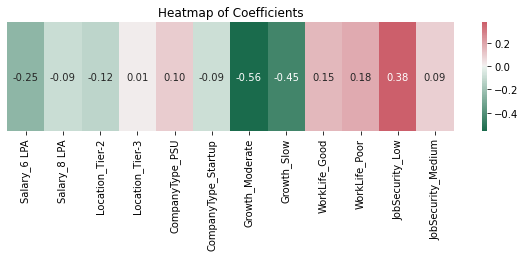

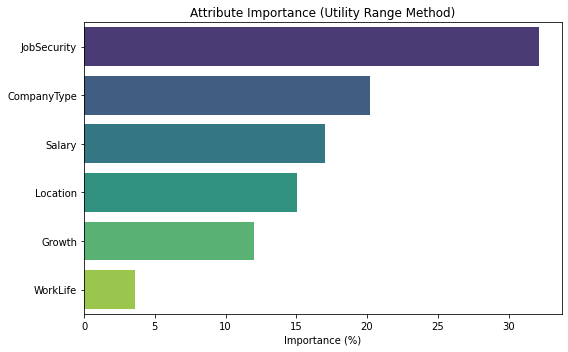

In [26]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load dataset ---
df = pd.read_csv("sample_conjoint_large.csv")  # Replace with your actual file

# --- 2. Define variables ---
categorical_cols = ['Salary', 'Location', 'CompanyType', 'Growth', 'WorkLife', 'JobSecurity']
y = df['Chosen']

# --- 3. One-hot encode categorical variables ---
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = encoder.fit_transform(df[categorical_cols])
feature_names = encoder.get_feature_names(categorical_cols)
X_df = pd.DataFrame(X_encoded, columns=feature_names)

# --- 4. Add constant & fit model ---
X_with_const = sm.add_constant(X_df)
model = sm.MNLogit(y, X_with_const)
result = model.fit()

# --- 5. Clean coefficient table (drop const) ---
coef_df = result.summary2().tables[1]
coef_df = coef_df[~coef_df.index.str.contains('const', case=False)]

# --- 6. Display coefficient table ---
print("Regression Coefficients (without constant):")
print(coef_df)

# --- 7. Attribute Importance (utility range method) ---
attribute_groups = {}
for feature in coef_df.index:
    attr_name = feature.split('_')[0]
    attribute_groups.setdefault(attr_name, []).append(coef_df.loc[feature, 'Coef.'])

# Compute utility ranges
attribute_ranges = {k: max(v) - min(v) for k, v in attribute_groups.items()}

# Normalize to 100%
total_range = sum(attribute_ranges.values())
importance_scores = {k: (v / total_range) * 100 for k, v in attribute_ranges.items()}

# --- 8. Display importance scores ---
print("\nAttribute Importance Scores (based on utility range):")
for attr, score in sorted(importance_scores.items(), key=lambda x: -x[1]):
    print(f"{attr}: {score:.2f}%")

# --- 9. Heatmap of coefficients ---
plt.figure(figsize=(10, 2))
sns.heatmap(
    coef_df[['Coef.']].T,
    cmap=sns.diverging_palette(150, 10, s=90, l=40, as_cmap=True),  # green to red
    center=0,
    annot=True,
    fmt=".2f",
    cbar=True
)
plt.title("Heatmap of Coefficients")
plt.yticks([])
plt.tight_layout()
plt.show()

# --- 10. Bar chart of attribute importance ---
plt.figure(figsize=(8, 5))
sorted_attrs = sorted(importance_scores.items(), key=lambda x: -x[1])
attrs, scores = zip(*sorted_attrs)

sns.barplot(x=list(scores), y=list(attrs), palette="viridis")
plt.xlabel("Importance (%)")
plt.title("Attribute Importance (Utility Range Method)")
plt.tight_layout()
plt.show()


C:\Users\Dhakaramaki\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\DHAKAR~1\AppData\Local\Temp/ipykernel_10180/1069706875.py:63: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


Optimization terminated successfully.
         Current function value: 0.624833
         Iterations 10
Regression Coefficients (without constant):
                              Chosen = 0     Coef.      Std.Err.  \
Salary_12 LPA              Salary_12 LPA  0.661903  2.130088e-01   
Salary_8 LPA                Salary_8 LPA  0.831283  2.467014e-01   
Location_Tier-2          Location_Tier-2 -0.427017  2.350248e-01   
Location_Tier-3          Location_Tier-3 -0.331937  2.176070e-01   
CompanyType_PSU          CompanyType_PSU -0.041315  2.291727e+06   
CompanyType_Startup  CompanyType_Startup  0.424406  3.487328e-01   
Growth_Moderate          Growth_Moderate  0.138192  2.636294e-01   
Growth_Slow                  Growth_Slow -0.849947  2.900127e-01   
WorkLife_Good              WorkLife_Good  0.392151  2.089910e-01   
WorkLife_Poor              WorkLife_Poor -0.796503  3.142695e-01   
JobSecurity_Low          JobSecurity_Low -1.106523  2.291727e+06   
JobSecurity_Medium    JobSecurity_Med

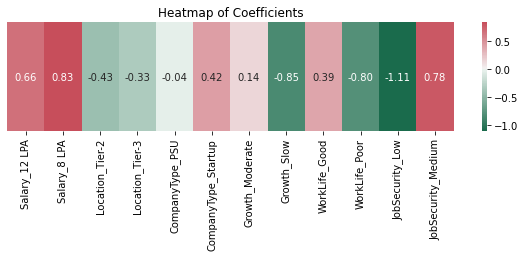

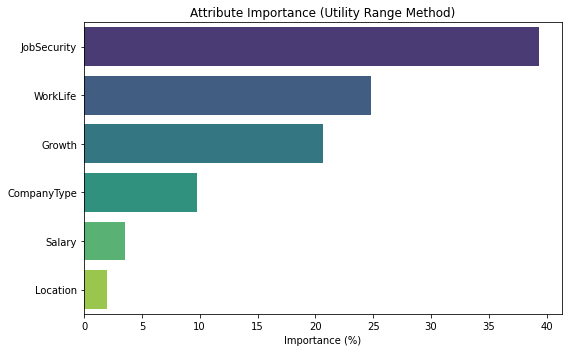

In [2]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load dataset ---
df = pd.read_csv("conjoint_transformed_sample_csv.csv")  # Replace with your actual file

# --- 2. Define variables ---
categorical_cols = ['Salary', 'Location', 'CompanyType', 'Growth', 'WorkLife', 'JobSecurity']
y = df['Chosen']

# --- 3. One-hot encode categorical variables ---
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = encoder.fit_transform(df[categorical_cols])
feature_names = encoder.get_feature_names(categorical_cols)
X_df = pd.DataFrame(X_encoded, columns=feature_names)

# --- 4. Add constant & fit model ---
X_with_const = sm.add_constant(X_df)
model = sm.MNLogit(y, X_with_const)
result = model.fit()

# --- 5. Clean coefficient table (drop const) ---
coef_df = result.summary2().tables[1]
coef_df = coef_df[~coef_df.index.str.contains('const', case=False)]

# --- 6. Display coefficient table ---
print("Regression Coefficients (without constant):")
print(coef_df)

# --- 7. Attribute Importance (utility range method) ---
attribute_groups = {}
for feature in coef_df.index:
    attr_name = feature.split('_')[0]
    attribute_groups.setdefault(attr_name, []).append(coef_df.loc[feature, 'Coef.'])

# Compute utility ranges
attribute_ranges = {k: max(v) - min(v) for k, v in attribute_groups.items()}

# Normalize to 100%
total_range = sum(attribute_ranges.values())
importance_scores = {k: (v / total_range) * 100 for k, v in attribute_ranges.items()}

# --- 8. Display importance scores ---
print("\nAttribute Importance Scores (based on utility range):")
for attr, score in sorted(importance_scores.items(), key=lambda x: -x[1]):
    print(f"{attr}: {score:.2f}%")

# --- 9. Heatmap of coefficients ---
plt.figure(figsize=(10, 2))
sns.heatmap(
    coef_df[['Coef.']].T,
    cmap=sns.diverging_palette(150, 10, s=90, l=40, as_cmap=True),  # green to red
    center=0,
    annot=True,
    fmt=".2f",
    cbar=True
)
plt.title("Heatmap of Coefficients")
plt.yticks([])
plt.tight_layout()
plt.show()

# --- 10. Bar chart of attribute importance ---
plt.figure(figsize=(8, 5))
sorted_attrs = sorted(importance_scores.items(), key=lambda x: -x[1])
attrs, scores = zip(*sorted_attrs)

sns.barplot(x=list(scores), y=list(attrs), palette="viridis")
plt.xlabel("Importance (%)")
plt.title("Attribute Importance (Utility Range Method)")
plt.tight_layout()
plt.show()


C:\Users\Dhakaramaki\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\DHAKAR~1\AppData\Local\Temp/ipykernel_10180/4116113883.py:72: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


Optimization terminated successfully.
         Current function value: 0.624833
         Iterations 28
Regression Coefficients (without constant):
                              Chosen = 0     Coef.      Std.Err.  \
Salary_10 LPA              Salary_10 LPA -0.661903  2.130088e-01   
Salary_8 LPA                Salary_8 LPA  0.169380  1.909357e-01   
Location_Tier-2          Location_Tier-2 -0.427017  2.350248e-01   
Location_Tier-3          Location_Tier-3 -0.331937  2.176070e-01   
CompanyType_PSU          CompanyType_PSU  0.124161  1.714971e+06   
CompanyType_Startup  CompanyType_Startup  0.424406  3.487328e-01   
Growth_Moderate          Growth_Moderate  0.138192  2.636294e-01   
Growth_Slow                  Growth_Slow -0.849947  2.900127e-01   
WorkLife_Good              WorkLife_Good  0.392151  2.089910e-01   
WorkLife_Poor              WorkLife_Poor -0.796503  3.142695e-01   
JobSecurity_Medium    JobSecurity_Medium  0.942882  1.714971e+06   
JobSecurity_Low          JobSecurity_

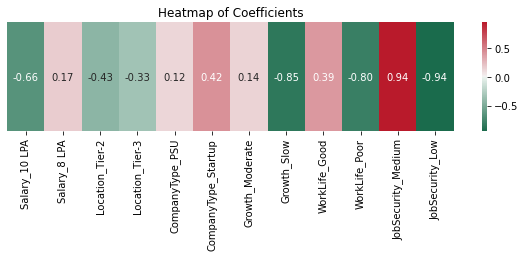

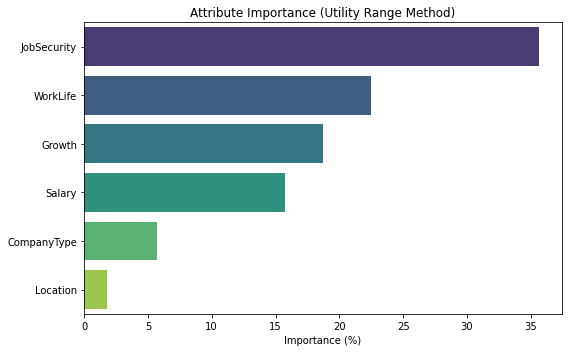

In [3]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load dataset ---
df = pd.read_csv("conjoint_transformed_sample_csv.csv")  # Replace with your actual file

# --- 2. Define variables ---
categorical_cols = ['Salary', 'Location', 'CompanyType', 'Growth', 'WorkLife', 'JobSecurity']
y = df['Chosen']

# --- 3. One-hot encode with 12 LPA as base for Salary ---
custom_categories = [
    ['12 LPA', '10 LPA', '8 LPA'],       # Salary (12 LPA is base)
    ['Tier-1', 'Tier-2', 'Tier-3'],      # Location
    ['MNC', 'PSU', 'Startup'],           # CompanyType
    ['Fast', 'Moderate', 'Slow'],        # Growth
    ['Excellent', 'Good', 'Poor'],       # WorkLife
    ['High', 'Medium', 'Low']            # JobSecurity
]

encoder = OneHotEncoder(categories=custom_categories, drop='first', sparse=False)
X_encoded = encoder.fit_transform(df[categorical_cols])
feature_names = encoder.get_feature_names(categorical_cols)
X_df = pd.DataFrame(X_encoded, columns=feature_names)

# --- 4. Add constant & fit model ---
X_with_const = sm.add_constant(X_df)
model = sm.MNLogit(y, X_with_const)
result = model.fit()

# --- 5. Clean coefficient table (drop const) ---
coef_df = result.summary2().tables[1]
coef_df = coef_df[~coef_df.index.str.contains('const', case=False)]

# --- 6. Display coefficient table ---
print("Regression Coefficients (without constant):")
print(coef_df)

# --- 7. Attribute Importance (utility range method) ---
attribute_groups = {}
for feature in coef_df.index:
    attr_name = feature.split('_')[0]
    attribute_groups.setdefault(attr_name, []).append(coef_df.loc[feature, 'Coef.'])

# Compute utility ranges
attribute_ranges = {k: max(v) - min(v) for k, v in attribute_groups.items()}

# Normalize to 100%
total_range = sum(attribute_ranges.values())
importance_scores = {k: (v / total_range) * 100 for k, v in attribute_ranges.items()}

# --- 8. Display importance scores ---
print("\nAttribute Importance Scores (based on utility range):")
for attr, score in sorted(importance_scores.items(), key=lambda x: -x[1]):
    print(f"{attr}: {score:.2f}%")

# --- 9. Heatmap of coefficients ---
plt.figure(figsize=(10, 2))
sns.heatmap(
    coef_df[['Coef.']].T,
    cmap=sns.diverging_palette(150, 10, s=90, l=40, as_cmap=True),  # green to red
    center=0,
    annot=True,
    fmt=".2f",
    cbar=True
)
plt.title("Heatmap of Coefficients")
plt.yticks([])
plt.tight_layout()
plt.show()

# --- 10. Bar chart of attribute importance ---
plt.figure(figsize=(8, 5))
sorted_attrs = sorted(importance_scores.items(), key=lambda x: -x[1])
attrs, scores = zip(*sorted_attrs)

sns.barplot(x=list(scores), y=list(attrs), palette="viridis")
plt.xlabel("Importance (%)")
plt.title("Attribute Importance (Utility Range Method)")
plt.tight_layout()
plt.show()
